In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Densenet121.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify
!ls /content/dataset


Densenet121


In [3]:
base_path = "/content/dataset/Densenet121"

train_dir = os.path.join(base_path, "Train")
val_dir   = os.path.join(base_path, "Validate")
test_dir  = os.path.join(base_path, "Test")

print("Train:", train_dir)
print("Validate:", val_dir)
print("Test:", test_dir)


Train: /content/dataset/Densenet121/Train
Validate: /content/dataset/Densenet121/Validate
Test: /content/dataset/Densenet121/Test


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical", shuffle=False
)

num_classes = len(train_generator.class_indices)


Found 14606 images belonging to 8 classes.
Found 4090 images belonging to 8 classes.
Found 6890 images belonging to 8 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers

base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Make ALL layers trainable (parameters ~8M+)
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # regularization
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # low LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,045,704 (26.88 MB)

 Trainable params: 6,962,056 (26.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True, monitor="val_loss"),
    ModelCheckpoint("best_densenet121.h5", save_best_only=True, monitor="val_accuracy"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]


In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,   # more epochs for fine-tuning
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.3099 - loss: 2.3611

457/457 ━━━━━━━━━━━━━━━━━━━━ 558s 839ms/step - accuracy: 0.3103 - loss: 2.3596 - val_accuracy: 0.7944 - val_loss: 0.6513 - learning_rate: 1.0000e-05
Epoch 2/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.7462 - loss: 0.7724

457/457 ━━━━━━━━━━━━━━━━━━━━ 257s 558ms/step - accuracy: 0.7463 - loss: 0.7722 - val_accuracy: 0.8983 - val_loss: 0.3261 - learning_rate: 1.0000e-05
Epoch 3/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.8383 - loss: 0.4850

457/457 ━━━━━━━━━━━━━━━━━━━━ 259s 567ms/step - accuracy: 0.8383 - loss: 0.4849 - val_accuracy: 0.9262 - val_loss: 0.2323 - learning_rate: 1.0000e-05
Epoch 4/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8755 - loss: 0.3637

457/457 ━━━━━━━━━━━━━━━━━━━━ 258s 557ms/step - accuracy: 0.8755 - loss: 0.3636 - val_accuracy: 0.9396 - val_loss: 0.1826 - learning_rate: 1.0000e-05
Epoch 5/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9016 - loss: 0.2957

457/457 ━━━━━━━━━━━━━━━━━━━━ 257s 562ms/step - accuracy: 0.9016 - loss: 0.2957 - val_accuracy: 0.9477 - val_loss: 0.1604 - learning_rate: 1.0000e-05
Epoch 6/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9104 - loss: 0.2672

457/457 ━━━━━━━━━━━━━━━━━━━━ 258s 562ms/step - accuracy: 0.9104 - loss: 0.2672 - val_accuracy: 0.9535 - val_loss: 0.1356 - learning_rate: 1.0000e-05
Epoch 7/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9207 - loss: 0.2300

457/457 ━━━━━━━━━━━━━━━━━━━━ 253s 553ms/step - accuracy: 0.9207 - loss: 0.2300 - val_accuracy: 0.9619 - val_loss: 0.1154 - learning_rate: 1.0000e-05
Epoch 8/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9252 - loss: 0.2148

457/457 ━━━━━━━━━━━━━━━━━━━━ 252s 552ms/step - accuracy: 0.9252 - loss: 0.2148 - val_accuracy: 0.9636 - val_loss: 0.1099 - learning_rate: 1.0000e-05
Epoch 9/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9371 - loss: 0.1840

457/457 ━━━━━━━━━━━━━━━━━━━━ 252s 551ms/step - accuracy: 0.9371 - loss: 0.1840 - val_accuracy: 0.9699 - val_loss: 0.0968 - learning_rate: 1.0000e-05
Epoch 10/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 250s 547ms/step - accuracy: 0.9396 - loss: 0.1714 - val_accuracy: 0.9692 - val_loss: 0.0942 - learning_rate: 1.0000e-05
Epoch 11/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9504 - loss: 0.1452

457/457 ━━━━━━━━━━━━━━━━━━━━ 253s 554ms/step - accuracy: 0.9504 - loss: 0.1452 - val_accuracy: 0.9743 - val_loss: 0.0848 - learning_rate: 1.0000e-05
Epoch 12/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9503 - loss: 0.1464

457/457 ━━━━━━━━━━━━━━━━━━━━ 251s 550ms/step - accuracy: 0.9503 - loss: 0.1464 - val_accuracy: 0.9753 - val_loss: 0.0797 - learning_rate: 1.0000e-05
Epoch 13/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9531 - loss: 0.1351

457/457 ━━━━━━━━━━━━━━━━━━━━ 253s 551ms/step - accuracy: 0.9532 - loss: 0.1351 - val_accuracy: 0.9765 - val_loss: 0.0753 - learning_rate: 1.0000e-05
Epoch 14/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9628 - loss: 0.1131

457/457 ━━━━━━━━━━━━━━━━━━━━ 262s 552ms/step - accuracy: 0.9628 - loss: 0.1131 - val_accuracy: 0.9795 - val_loss: 0.0653 - learning_rate: 1.0000e-05
Epoch 15/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9628 - loss: 0.1133

457/457 ━━━━━━━━━━━━━━━━━━━━ 254s 556ms/step - accuracy: 0.9628 - loss: 0.1133 - val_accuracy: 0.9800 - val_loss: 0.0664 - learning_rate: 1.0000e-05
Epoch 16/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9672 - loss: 0.0992

457/457 ━━━━━━━━━━━━━━━━━━━━ 251s 549ms/step - accuracy: 0.9672 - loss: 0.0992 - val_accuracy: 0.9807 - val_loss: 0.0650 - learning_rate: 1.0000e-05
Epoch 17/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 252s 551ms/step - accuracy: 0.9685 - loss: 0.0923 - val_accuracy: 0.9807 - val_loss: 0.0647 - learning_rate: 1.0000e-05
Epoch 18/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 251s 548ms/step - accuracy: 0.9713 - loss: 0.0878 - val_accuracy: 0.9792 - val_loss: 0.0638 - learning_rate: 1.0000e-05
Epoch 19/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 252s 552ms/step - accuracy: 0.9767 - loss: 0.0732 - val_accuracy: 0.9804 - val_loss: 0.0690 - learning_rate: 1.0000e-05
Epoch 20/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9764 - loss: 0.0711

457/457 ━━━━━━━━━━━━━━━━━━━━ 253s 553ms/step - accuracy: 0.9764 - loss: 0.0711 - val_accuracy: 0.9824 - val_loss: 0.0629 - learning_rate: 1.0000e-05
Epoch 21/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 251s 549ms/step - accuracy: 0.9795 - loss: 0.0640 - val_accuracy: 0.9814 - val_loss: 0.0590 - learning_rate: 1.0000e-05
Epoch 22/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9755 - loss: 0.0723

457/457 ━━━━━━━━━━━━━━━━━━━━ 249s 545ms/step - accuracy: 0.9755 - loss: 0.0723 - val_accuracy: 0.9829 - val_loss: 0.0617 - learning_rate: 1.0000e-05
Epoch 23/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9835 - loss: 0.0542

457/457 ━━━━━━━━━━━━━━━━━━━━ 251s 549ms/step - accuracy: 0.9835 - loss: 0.0542 - val_accuracy: 0.9834 - val_loss: 0.0633 - learning_rate: 1.0000e-05
Epoch 24/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9828 - loss: 0.0563
Epoch 24: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
457/457 ━━━━━━━━━━━━━━━━━━━━ 250s 546ms/step - accuracy: 0.9828 - loss: 0.0563 - val_accuracy: 0.9824 - val_loss: 0.0730 - learning_rate: 1.0000e-05
Epoch 25/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9852 - loss: 0.0493

457/457 ━━━━━━━━━━━━━━━━━━━━ 251s 549ms/step - accuracy: 0.9852 - loss: 0.0493 - val_accuracy: 0.9841 - val_loss: 0.0631 - learning_rate: 5.0000e-06
Epoch 26/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 251s 550ms/step - accuracy: 0.9848 - loss: 0.0483 - val_accuracy: 0.9839 - val_loss: 0.0620 - learning_rate: 5.0000e-06
Epoch 27/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9867 - loss: 0.0449


Epoch 27: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
457/457 ━━━━━━━━━━━━━━━━━━━━ 251s 548ms/step - accuracy: 0.9867 - loss: 0.0449 - val_accuracy: 0.9851 - val_loss: 0.0605 - learning_rate: 5.0000e-06
Epoch 28/40
457/457 ━━━━━━━━━━━━━━━━━━━━ 254s 555ms/step - accuracy: 0.9874 - loss: 0.0374 - val_accuracy: 0.9844 - val_loss: 0.0638 - learning_rate: 2.5000e-06


In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


216/216 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.8996 - loss: 1.1696
✅ Test Accuracy: 90.54%


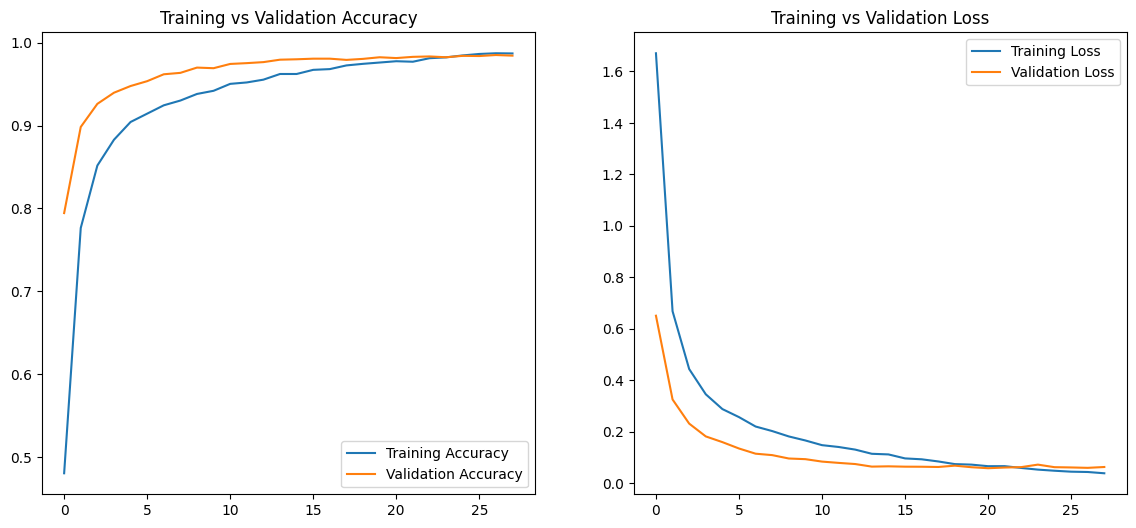

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14,6))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step


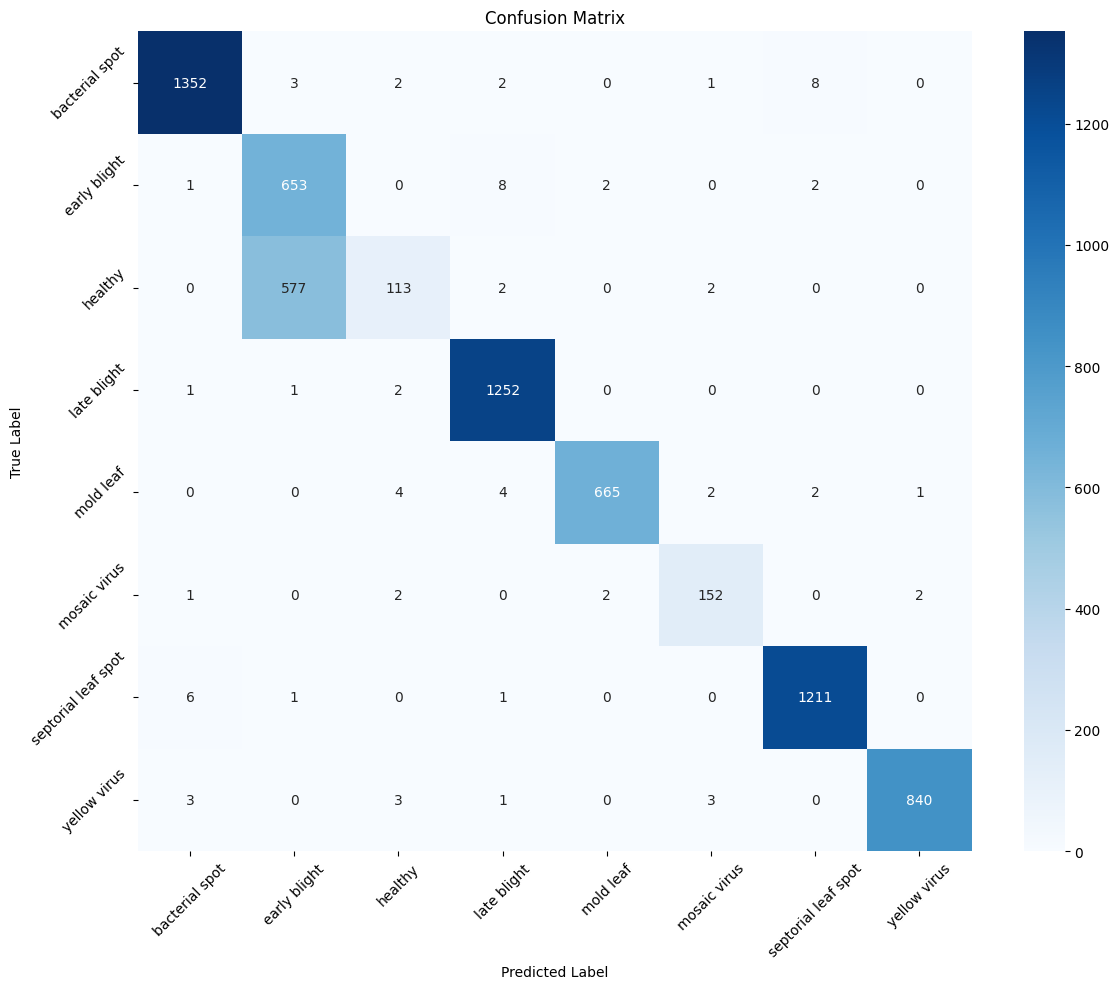

Classification Report:

                     precision    recall  f1-score   support

     bacterial spot       0.99      0.99      0.99      1368
       early blight       0.53      0.98      0.69       666
            healthy       0.90      0.16      0.28       694
        late blight       0.99      1.00      0.99      1256
          mold leaf       0.99      0.98      0.99       678
       mosaic virus       0.95      0.96      0.95       159
septorial leaf spot       0.99      0.99      0.99      1219
       yellow virus       1.00      0.99      0.99       850

           accuracy                           0.91      6890
          macro avg       0.92      0.88      0.86      6890
       weighted avg       0.94      0.91      0.89      6890



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Step 1: Get predictions
y_pred_probs = model.predict(test_generator)   # probabilities
y_pred = np.argmax(y_pred_probs, axis=1)       # predicted labels
y_true = test_generator.classes                # true labels
class_labels = list(test_generator.class_indices.keys())

# Step 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 3: Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [12]:
# Path to save in Drive
save_path = "/content/drive/MyDrive/Densenet121_trained.h5"

# Save the model
model.save(save_path)

print(f"✅ Model saved at: {save_path}")


✅ Model saved at: /content/drive/MyDrive/Densenet121_trained.h5
